In this recipe, we want to introduce a vulnerability called adversarial examples or attacks. Adversarial examples are a type of input data that can significantly change the model prediction without being noticeable to the human eye. Due to this fact, adversarial examples can be worrisome, especially in critical tasks such as the security or healthcare domains. It would be beneficial to learn how these attacks work in order to start thinking about possible solutions.

There are two types of adversarial attacks:
- White box
- Black Box

- White Box: The attacker has the knowledge of the model, input, and loss function that was used to train the model. By using this knowledge, the attacker can change the inputs to disrupt the predicted outputs. The amount of change in the input is usually minor and indistinguishable to the human eye. A common type of white box attack is called the Fast Gradient Sign (FGS) attack, which works by changing the input to maximize the loss.

In this recipe, you will learn how to develp an FGS attack for the binary classification.

**Fast Gradient Sign (FGS)** works by changing the input to maximize the loss. In the FGS attack, given an input and a pre-trained model, we compute the gradients of the loss with respect to the input. Then, we add a small portion of the absolute value of gradients to the input.

# Getting ready

## Loading the dataset

### 1. Import the Python file provided to you to build the dataset:

In [1]:
import mydataset

### 2. Define an object of the dataloader and get a mini-batch:

In [2]:
test_dl = mydataset.test_dl

for xb, yb in test_dl:
    print(xb.shape, yb.shape)
    break

torch.Size([1, 3, 96, 96]) torch.Size([1])


## Loading the pretrained model

### 1. Import the pre-trained model: 

In [3]:
import mymodel

### 2. Define an object of the pre-trained model:

In [4]:
model = mymodel.model

### 3. Move the model to the CUDA device:

In [5]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

### 4. Define a helper function to freeze the model parameters:

In [6]:
def freeze_model(model):
    for child in model.children():
        for param in child.parameters():
            param.requires_grad = False
    print("model frozen")
    return model

### 5. Call the helper function to freeze the model:

In [7]:
model = freeze_model(model)

model frozen


### 6. Deploy the pre-trained model on some sample test data:

In [9]:
from sklearn.metrics import accuracy_score
import numpy as np

def deploy_model(model, test_dl):
    y_pred = []
    y_gt = []
    
    with torch.no_grad():
        for x, y in test_dl:
            y_gt.append(y.item())
            out = model(x.to(device)).cpu().numpy()
            out = np.argmax(out, axis=1)[0]
            y_pred.append(out)
    
    return y_pred, y_gt

y_pred, y_gt = deploy_model(model, test_dl)

### 7. Verify the pre-trained model's performance on the sample test data:

In [10]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_pred, y_gt)
print("accuracy: %.2f" %acc)

accuracy: 0.93


## Implementing the attack

We will implement the attack and display sample adversarial examples:

### 1. Import the required packages:

In [14]:
def perturb_input(xb, yb, model, alfa):
    xb = xb.to(device)
    xb.requires_grad = True
    out = model(xb).cpu()
    loss = F.nll_loss(out, yb)
    model.zero_grad()
    loss.backward()
    xb_grad = xb.grad.data
    xb_p = xb + alfa * xb_grad.sign()
    xb_p = torch.clamp(xb_p, 0, 1)
    
    return xb_p, out.detach()

In [12]:
from torchvision.transforms.functional import to_pil_image
import torch.nn.functional as F
import matplotlib.pyplot as plt

### 2. Get mini-batches from the dataloader and call perturb_input:

In [15]:
y_pred = []
y_pred_p = []

for xb, yb in test_dl:
    xb_p, out = perturb_input(xb, yb, model, alfa=0.005)

### 4. Calculate the prediction probabilities before and after perturbation:

In [16]:
with torch.no_grad():
    pred = out.argmax(dim=1, keepdim=False).item()
    y_pred.append(pred)
    prob = torch.exp(out[:, 1])[0].item()
    
    out_p = model(xb_p).cpu()
    pred_p = out_p.argmax(dim=1, keepdim=False).item()
    y_pred_p.append(pred_p)
    prob_p = torch.exp(out_p[:, 1])[0].item()

### 5. Display the original and perturbed input:

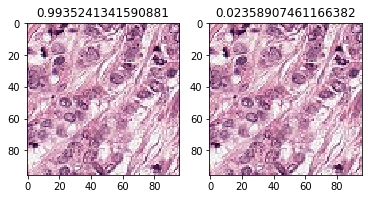

In [17]:
plt.subplot(1, 2, 1)
plt.imshow(to_pil_image(xb[0].detach().cpu()))
plt.title(prob)
plt.subplot(1, 2, 2)
plt.imshow(to_pil_image(xb_p[0].detach().cpu()))
plt.title(prob_p)
plt.show()

### 6. Let's compute the model accuracy for the perturbed data:

In [18]:
acc = accuracy_score(y_pred, y_gt)
print("accuracy: %.2f" %acc)

ValueError: Found input variables with inconsistent numbers of samples: [1, 100]